In [ ]:
import numpy as np
from importlib import reload
import fdc
import tqdm
fdc=reload(fdc)
import matplotlib.pyplot as plt

# REAL DATA

In [ ]:
# load the data



# Simple random process with coupled Oersten-Uhlembeck 

In [2]:
N = 83
x = np.random.randn(N, 1000) / np.sqrt(N)
np.shape(np.triu(x))

(83, 1000)

In [3]:
time_step = 1
frequency = 250
n_chunks = 1

In [4]:
s = fdc.correlation_freq(x,time_step,frequency)

In [5]:
np.shape(s) #matrixe di correlazione integrate

(83, 83)

In [6]:
np.mean(np.diag(s).real)

np.float64(1.4264426352603729e-05)

In [7]:
sii = []
for freq in np.linspace(1,50,1000):
    s = fdc.correlation_freq(x,time_step,freq)
    smean = np.mean(np.diag(s).real)
    #print(smean)
    sii.append(smean)
    

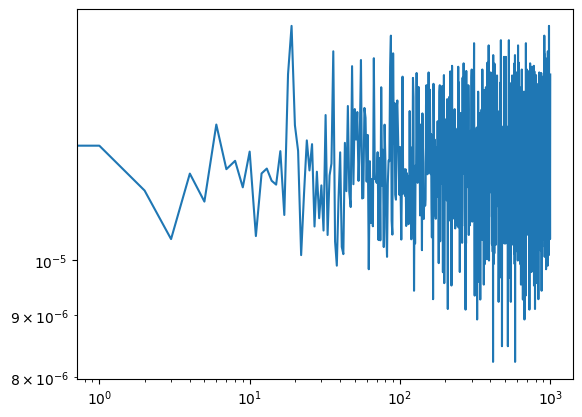

In [8]:
plt.plot(sii)
plt.xscale('log')
plt.yscale('log')


In [9]:
def generate_OU(J, T=20000, dt=1, sigma=1.0, g=None):
    """
    Generate multivariate Ornstein-Uhlenbeck (OU) process.
    
    Parameters
    ----------
    N : number of nodes
    T : number of time points
    dt : timestep in seconds
    g : global coupling (scales J)
    sigma : noise amplitude

    Returns
    -------
    X : array shape (N, T)
        OU time series ready to use with correlation_freq()
    """
    # Random Gaussian connectivity (consistent with the paper's theory)

    N = len(J)

    if g == None:
        lambdamax = np.max(np.linalg.eigvals(J))
        g = 1/lambdamax - 0.1
    
    X = np.zeros((N, T))
    noise_scale = np.sqrt(sigma * dt)

    for t in range(T-1):
        drift = (-X[:, t] + g * J @ X[:, t])
        noise = noise_scale * np.random.randn(N) 
        X[:, t+1] = X[:, t] + dt * drift + noise

    # Removing transient (optional)
    return X#[:, 5000:]   # discard first 5k samples


In [ ]:
def generate_OU(J, T=20000, dt=0.01, sigma=1.0, g=None, burn_in=0):
    """
    Generate multivariate Ornstein-Uhlenbeck (OU) process.
    
    Implements:
        dx_i/dt = -x_i + g * sum_j J_ij * x_j + sigma * xi_i(t)
    
    where xi_i(t) is white noise with <xi_i(t)xi_j(s)> = delta_ij * delta(t-s)
    
    Parameters
    ----------
    J : np.ndarray, shape (N, N)
        Connectivity matrix
    T : int
        Number of time points
    dt : float
        Time step (in seconds). Default: 0.01
    sigma : float
        Noise amplitude. Default: 1.0
    g : float, optional
        Global coupling strength (scales J).
        If None, sets g = 1/lambda_max - 0.1 (near critical)
    burn_in : int
        Number of initial time steps to discard (transient removal)
        
    Returns
    -------
    X : np.ndarray, shape (N, T - burn_in)
        OU time series ready to use with correlation_freq()
    """
    N = len(J)
    
    # Set coupling strength
    if g is None:
        # Near the edge of instability
        lambdamax = np.max(np.real(np.linalg.eigvals(J)))
        g = 1.0 / lambdamax - 0.1
        print(f"Auto-setting g = {g:.4f} (lambda_max = {lambdamax:.4f})")
    
    # Initialize
    X = np.zeros((N, T))
    X[:, 0] = np.random.randn(N) * 0.1  # Small random initial condition
    
    # Euler-Maruyama integration
    noise_scale = sigma * np.sqrt(dt)  
    
    for t in range(T - 1):
        # Deterministic part
        drift = -X[:, t] + g * (J @ X[:, t])
        
        # Stochastic part
        noise = noise_scale * np.random.randn(N)
        
        # Update
        X[:, t + 1] = X[:, t] + dt * drift + noise
    
    # Remove transient if requested
    if burn_in > 0:
        return X[:, burn_in:]
    
    return X

## random example

In [156]:
N = 83
A = np.random.randn(N, N) / np.sqrt(N)
J = (A + A.T) / 2

In [189]:
tp = 128
T = tp*30
dt=1/tp
x = generate_OU(J, T, dt, sigma=2, g=None)

Auto-setting g = 0.6218 (lambda_max = 1.3853)


In [190]:
N

80

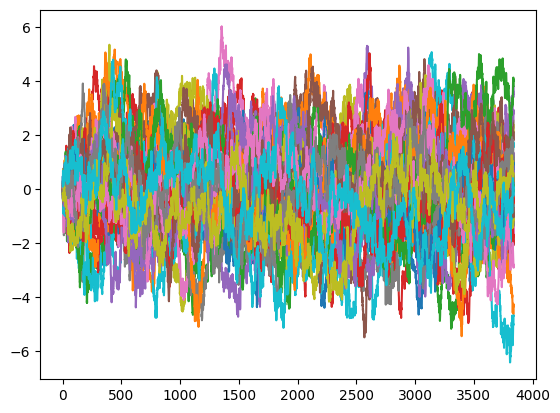

In [191]:
plt.plot(x.T);

In [192]:
np.shape(x)

(40, 3840)

In [193]:
x.shape = (N, T)   # Your OU data
dt  

ValueError: cannot reshape array of size 153600 into shape (80,3840)

In [ ]:
freqs = np.linspace(0.0001, 100, 1000) #np.logspace(-3, 2., 50)  
omegas = 2 * np.pi * freqs

In [ ]:
C_freq = np.zeros((N, N, len(freqs)), dtype=complex)
S_ii = []

for i, f in enumerate(freqs):
    cif = fdc.correlation_freq(
        x,
        time_step=dt,
        frequency=f,
        n_chunks=10,          # important for unbiased estimator
        corr_type="covariance"
    )
    C_freq[:, :, i] = cif
    S_ii.append(np.mean(np.diag(cif)))


/opt/homebrew/lib/python3.10/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/homebrew/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


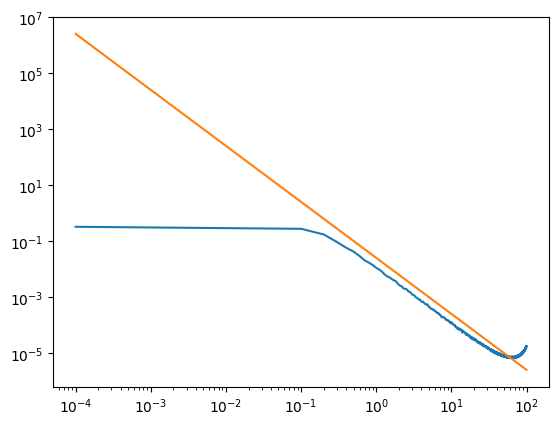

In [ ]:
plt.loglog(freqs,S_ii)
plt.plot(freqs,1/omegas**2)
#plt.xlim(10e0,10)

# Block diagonal case 

In [333]:
N = 80

tp = 128
T = tp * 1000  # = 12800 time steps (~100 s con dt=1/128)
dt = 1/tp
burn_in = tp * 100  # Rimuovi transiente

sigma = 1

#freqs = np.linspace(1e-3, 100, 1000) #
freqs = np.logspace(-3, 1, 1000)  
omegas = 2 * np.pi * freqs


A = np.random.randn(int(N/2), int(N/2)) / np.sqrt(int(N/2))
J = (A + A.T) / 2
#J = J - np.diag(np.diag(J))  # remove self-connections
alpha = 1

if alpha < 1: 
    g = 1/(2*alpha) - 0.1
else:
    g = 1/(2*alpha) -0.1
beta = 5

print("g:", g)


omega_peak = 2 * beta * g / alpha  # In rad/s
f_peak = omega_peak / (2 * np.pi)  # In Hz

print("f_peak (Hz):", f_peak)   

W = np.block([
        [ alpha * J,  -beta * J ],
        [ beta  * J,   alpha * J ]
    ])

# generate process
x = generate_OU(W, T, dt, sigma=sigma, g=g, burn_in=burn_in)

g: 0.4
f_peak (Hz): 0.6366197723675814


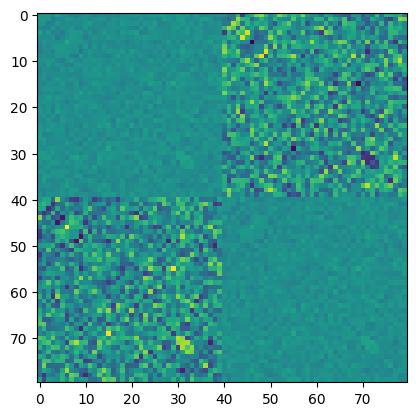

In [334]:
plt.imshow(W)

KeyboardInterrupt: 

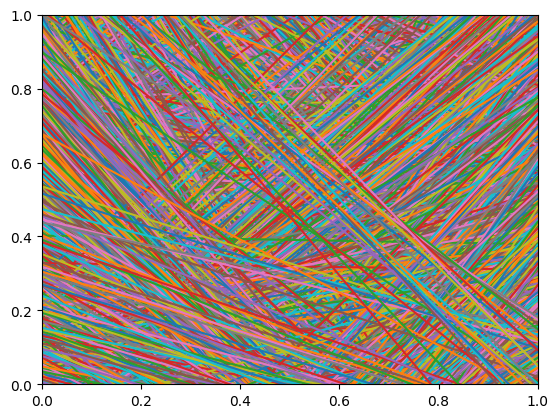

In [335]:
plt.plot(x)
plt.show()

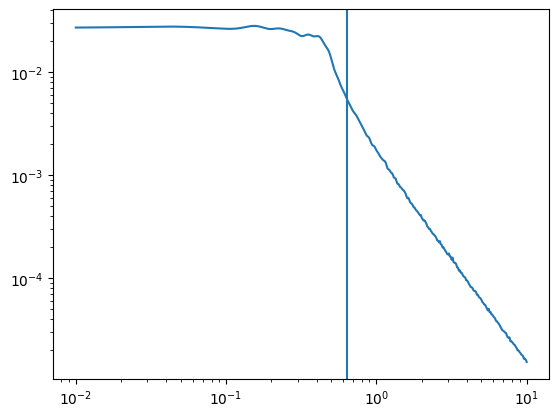

In [337]:
plt.loglog(freqs,S_ii)
#plt.plot(freqs,1/omegas**2*10e12) 
plt.axvline(f_peak)

In [338]:
np.argmax(S_ii)

np.int64(197)

In [339]:
freqs[np.argmax(S_ii)]

np.float64(0.15288635880587303)

In [340]:
beta/(alpha)

5.0

In [341]:
g

0.4

In [342]:
2*g*beta/alpha

4.0